In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import emcee
import multiprocess as mp


In [114]:
# Dados começam 06/03/2020
# Vacinação começa 19/01/2022

Psi = pd.read_csv('../../../dados_usados/psi.csv')

dados = pd.read_csv("../../../dados_usados/dados").values

dados_datas = dados[:,1][:-1]
dados_casos = dados[:,2][:-1]
dados_mortes = dados[:,3][:-1]
dados_hospitalizados = dados[:,4][:-1]
dados_hospitalizados_vacinados = dados[:,5][:-1]
dados_infectados_vacinados = dados[:,6][:-1]
dados_vacinados_acumulados = dados[:,7][:-1]


In [115]:
# Facendo média móvel do PSI
copy = Psi.copy()
Psi = np.append(Psi, copy)
Psi = Psi

npd = len(Psi)
Nfo = 8

Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)

[0]

In [116]:
# evitando valores negativos nas vacinações diárias

vacinados_dados_aux =  np.copy(dados_vacinados_acumulados)
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados =  np.diff(vacinados_dados_aux)
novos_vacinados = novos_vacinados.tolist()
novos_vacinados.insert(0, 0)

In [117]:
# Parametros do modelo
# Ultima revisão: 05/01/2023
k = 1/4
gamma_a = 1/3.5
gamma_s = 1/4
gamma_h = 0.18
gamma_u = 0.13
mi_u = 0.4
qsi = 0.53 
h = 0.06
h_v = 0.012
mi_h = 0.15
ome_h = 0.14
ome_u = 0.29

N=14136417

In [118]:
# define beta em função do tempo
def define_beta(t, b0, b1, t0, p0, p1, p_v0, p_v1):
    p = 0.2
    delta = 0.31

    # tanto faz a troca de ordem dos deltas pois são todos 0
    if t<20.178:
        return (2.1317, p, 0, delta, 0, 0)
    elif (t>=20.178-8) and (t < 72):
        return (1.7645, p, 0, delta, 0, 0)
    elif (t>=72) and (t < 149.34736536):
        return (1.1281, p, 0, delta, 0, 0)
    elif (t >= 149.34736536) and (t < 235):
        return (1, p, 0, delta, 0, 0)
    elif(t >= 235 and t < 246.94452773):
        return (1.39366795, p, 0, delta, 0, 0)
    elif (t >= 246.94452773 and t <= t0):
        return (b0, p0, p_v0, delta, delta, delta)
    elif (t >= t0):
        return (b1, p1, p_v1, delta, delta, delta)

In [119]:
# define parametros em função do inicio da vacinação
def parametros_vacina(t):
    if t >= 321: # 321 é quando começa a vacina
        phi_e = 0.7
        k_v=1/3
        gamma_av = 1/3.5
        gamma_sv = 1/4
        gamma_vu=0.26
        qsi_v = 0.99
        
        eps=.75

        mi_vh=0.03  
        mi_vu=0.08
        gamma_vh=0.36
    else:
        phi_e = 0
        k_v=0
        gamma_av = 0
        gamma_sv = 0
        gamma_vu=0
        qsi_v = 0
        eps=0
        mi_vh=0
        mi_vu=0
        gamma_vh=0

    return (phi_e, k_v, gamma_av, gamma_sv, gamma_vu, qsi_v, eps, mi_vh, mi_vu, gamma_vh)

In [120]:
y1 = np.r_[np.diff(dados_mortes)[:-1], np.diff(dados_casos)[:-1], np.diff(dados_infectados_vacinados)[:-1]]

In [121]:
# condições iniciais

D0          = 0
N0          = 14136417
R0          = 0
H0          = 0
HV0         = 0
U0          = 0
UV0         = 0
V0          = 0
Rv0         = 0
Is0         = 2.015439771376298e-06
Ia0         = 1.8028646508967777e-06
Iav0        = 1.8028646508967777e-06 
Isv0        = 1.8028646508967777e-06 
E0          = 1.7639153732952095e-06
Ev0         = 1.7639153732952095e-06
S0          = (1-Is0-Ia0-E0)
Sv0         = 0 
Nw0         = 0
NwV0        = 0

condicoes_iniciais = [S0,E0,V0, Sv0, Ev0, Ia0, Is0, Iav0, Isv0, H0, HV0, U0, UV0, R0, Rv0, D0, Nw0, NwV0, 0, 0, 0]

In [122]:
# Modelo com leaky

def SEIIHURD(t, y, args):
    b0, b1, t0, p0, p1, p_v0, p_v1 = args
    beta, p, p_v, delta, delta_sv, delta_av = define_beta(t, b0, b1, t0, p0, p1, p_v0, p_v1)

    beta_v = beta

    tau = novos_vacinados[int(t)]

    phi_e, k_v, gamma_av, gamma_sv, gamma_vu, qsi_v, eps, mi_vh, mi_vu, gamma_vh = parametros_vacina(t)

    psi = Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]
    NHn=y[18]
    NHnV=y[19]
    NIAv=y[20]

    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    dEdt = (beta*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))*(S+V) - k*E
    dVdt = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*V*(1-eps) - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev    
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv)+ phi_e*V*eps
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E
    dNwVdt = tau/N
    dHndt = h*qsi*gamma_s*Is
    dHnvdt = h_v*qsi_v*gamma_sv*Isv
    dNIAvdt = p_v*k_v*Ev

    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
            dRvdt, dDdt, dNwdt, dNwVdt, dHndt, dHnvdt, dNIAvdt]

## Funções do MCMC

In [123]:
def model(theta):    
    sol = solve_ivp(fun = SEIIHURD, t_span = [0, len(novos_vacinados)-1], args=(theta,),y0 = condicoes_iniciais, t_eval=np.arange(len(novos_vacinados)-1))
    novos_mortos = np.diff(sol.y[-6,:]).astype(float)
    novos_casos = np.diff(sol.y[-5,:]).astype(float)
    infectados_vacinados = np.diff(sol.y[-1,:]).astype(float)
    return np.r_[novos_mortos*N, novos_casos*N, infectados_vacinados*N]

def lnlike(theta):
    model_dados = model(theta)
    return -0.5 * np.sum(((y1 - model_dados)/0.05) ** 2)

def lnprior(theta):
    b0, b1, t0, p0, p1, p_v0, p_v1 = theta
    
    if (
            0 < b0 < 5
        and 0 < b1 < 5 
        and 320 < t0 < 400 
        and 0.31 < p0 < 0.99 
        and 0.31 < p1 < 0.99 
        and 0.31 < p_v0 < 0.99 
        and 0.31 < p_v1 < 0.99 

    ): 
        return 0.0
    return -np.inf

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf

    likelihood = lp + lnlike(theta)
    return likelihood

def main(p0,nwalkers,niter,ndim, pool):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter,progress=True)

    return sampler, pos, prob, state

In [124]:
nwalkers = 250; niter = 500

In [125]:
# #Intervalo das condições iniciais para o cenário inicial

intervals= np.array(    [
                         [0, 5], #b1
                         [0, 5], #b2
                         [320, 400], #t1
                         [0.3, 0.9], #p_v
                         [0.3, 0.9], #p_v1
                         [0.3, 0.9], #p_v
                         [0.3, 0.9], #p_v1
                       ])
par0 = np.random.rand(len(intervals))
initial = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

if __name__ == '__main__':
  with mp.Pool() as pool:
    sampler1, pos1, prob1, state1 = main(p0,nwalkers,niter,ndim, pool)
    samples1 = sampler1.flatchain
    theta_max1  = samples1[np.argmax(sampler1.flatlnprobability)]
    sol1 = solve_ivp(fun = SEIIHURD, t_span = [0, len(novos_vacinados)-1], args=(theta_max1,),y0=condicoes_iniciais, t_eval=np.arange(len(novos_vacinados)-1))
# theta_max1 = [9.68251245e-01, 1.24284572e+00, 3.99313918e+02, 3.64828359e-01,4.52660549e-01, 8.60479427e-01, 5.97387059e-01]       
       

Running burn-in...
Running production...


100%|██████████| 500/500 [1:42:40<00:00, 12.32s/it]   


In [126]:
theta_max1

array([4.99979275e+00, 1.81553824e-01, 3.82595584e+02, 9.89964662e-01,
       8.90160611e-01, 4.01524761e-01, 9.13811866e-01])

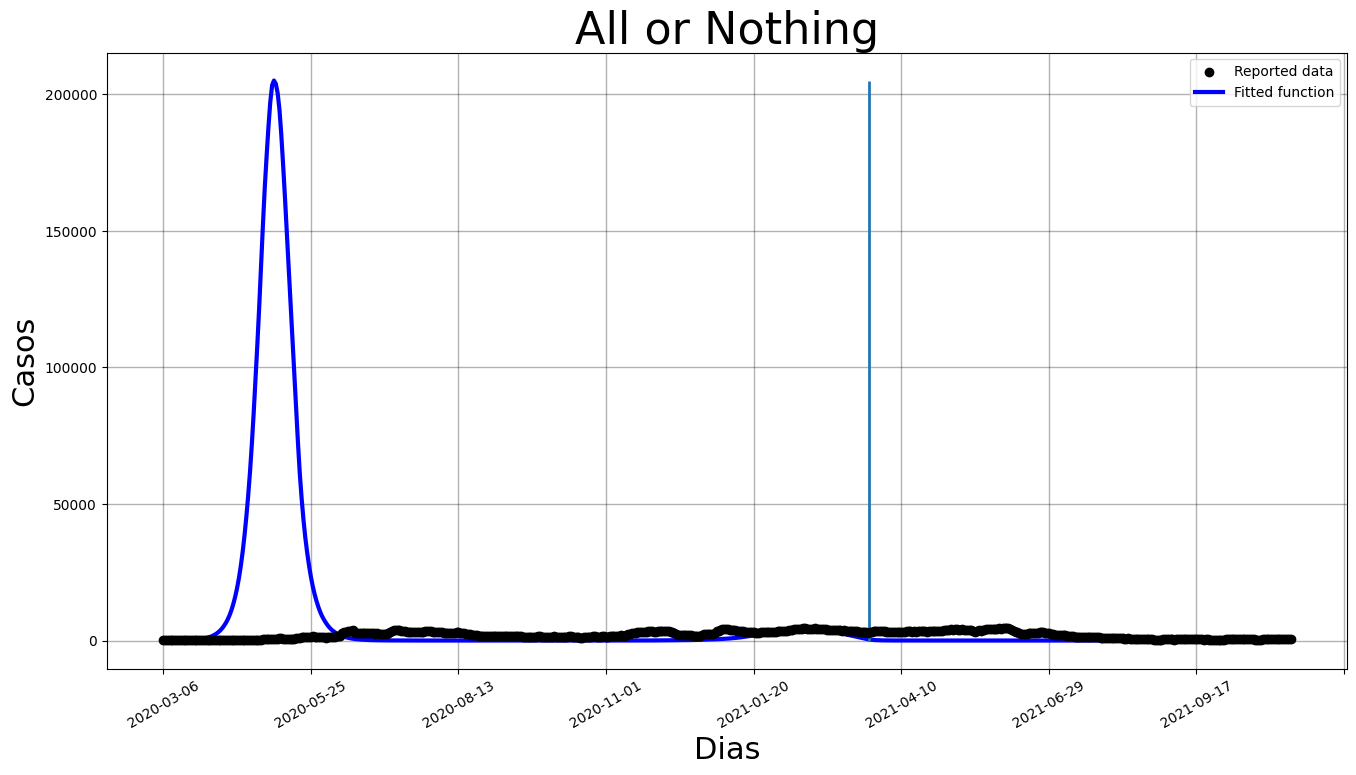

In [127]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = sol1.y[-5,:] #mortes acumulados

#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

plt.title("All or Nothing", fontsize=32)

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-1, 1)
ax.scatter(dados_datas[:-1],  np.diff(dados_casos), color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(dados_datas[:-2], np.diff(N*qi),color='blue',label='Fitted function', linewidth=3)
#Set the labels
ax.set_ylabel('Casos',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)
# plt.vlines([ 333.15303923, 439.95810453], ymin=0, ymax=200)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=10)
plt.vlines([theta_max1[2]], ymin=0, ymax=max(np.diff(qi*N)), linewidth=2)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
plt.setp(ax.get_xticklabels(), rotation=30)

plot_mortes = fig
plt.legend()
#Show Graph       
plt.show()

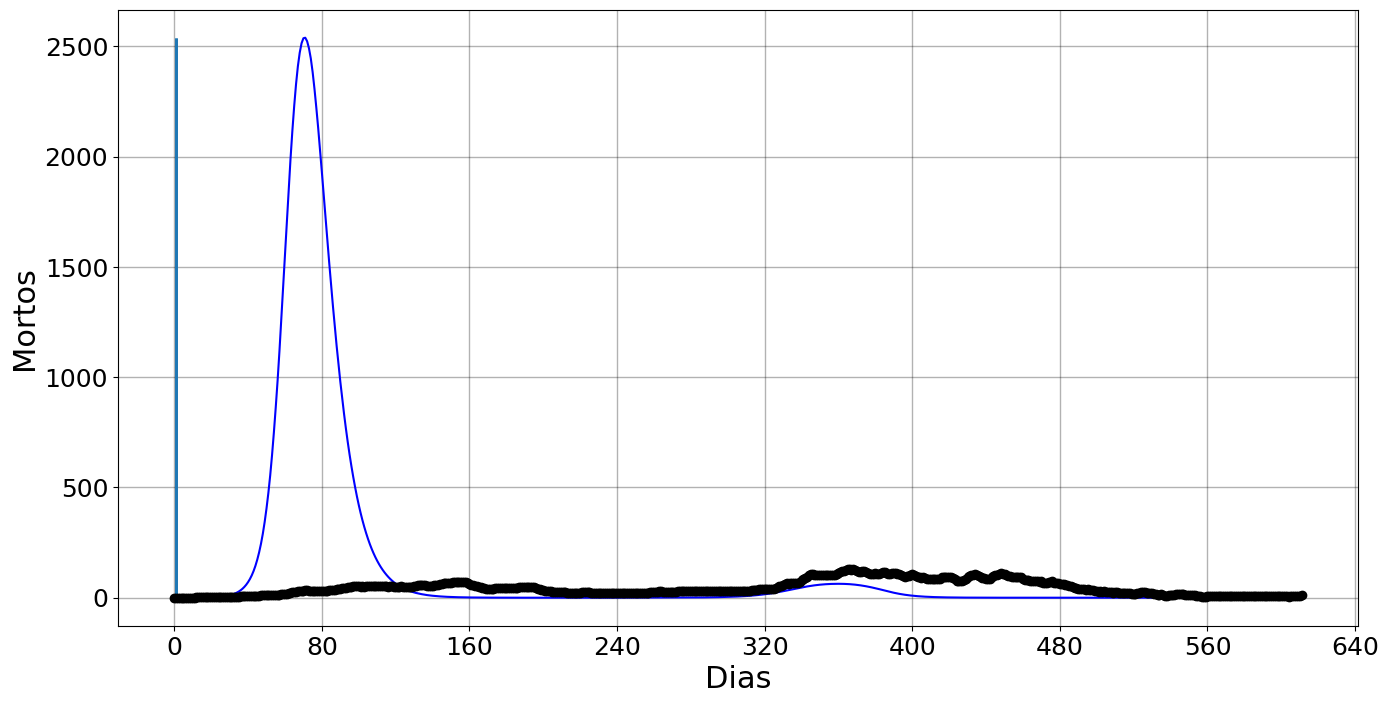

In [128]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = sol1.y[-6,:] #mortes acumulados

#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-1, 1)

ax.scatter(x_para_escala,  np.diff(dados_mortes), color='black',zorder=3,label='Reported data')
#Plot the fitted function as a line.
ax.plot(np.diff(N*qi),color='blue',label='Fitted function')
#Set the labels
ax.set_ylabel('Mortos',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)

# plt.vlines([ 333.15303923, 439.95810453], ymin=0, ymax=200)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)
# plt.vlines([t0, t1], ymin=0, ymax=max(np.diff(qi*N)), linewidth=2)
plt.vlines([theta_max1[3], theta_max1[4]], ymin=0, ymax=max(np.diff(qi*N)), linewidth=2)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
plot_casos = fig

#Show Graph       
plt.show()

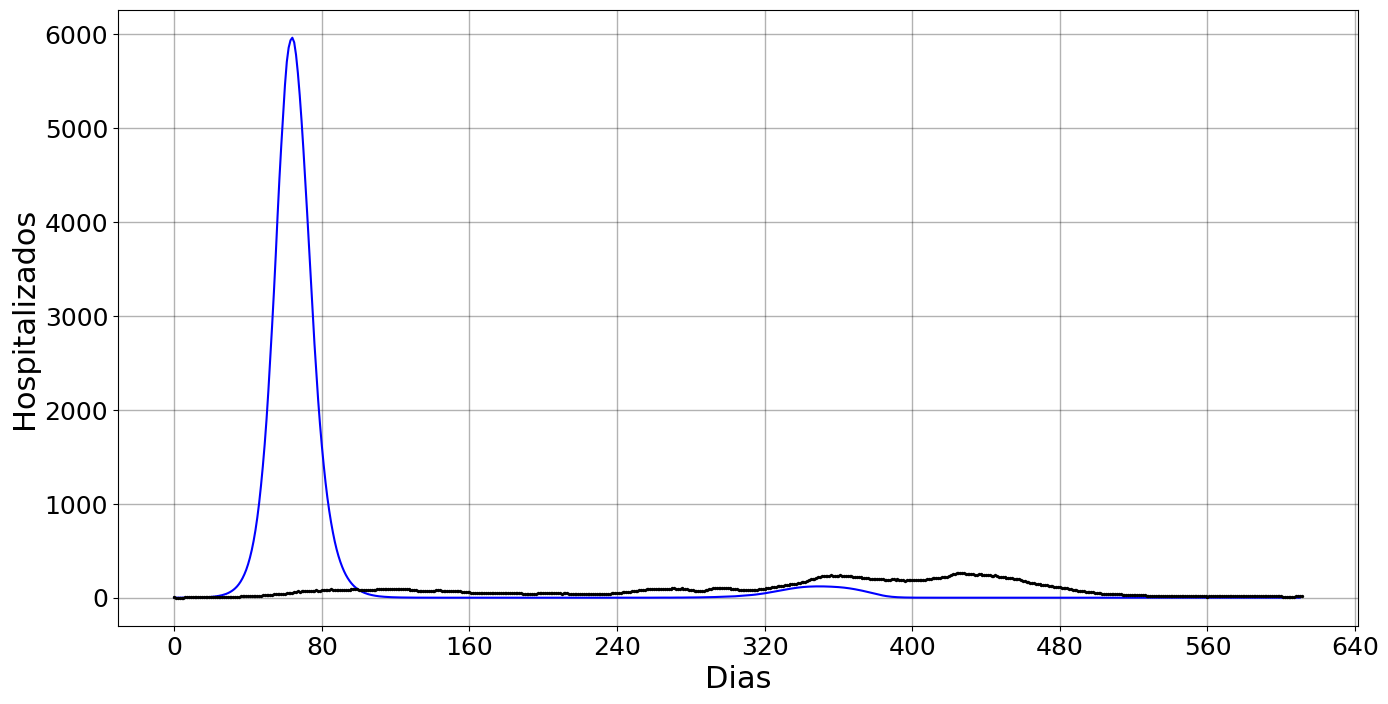

In [129]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = sol1.y[-3,:] #mortes acumulados

#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-1, 1)

ax.scatter(x_para_escala,  np.diff(dados_hospitalizados), color='black',zorder=3,label='Reported data', s=2)
#Plot the fitted function as a line.
ax.plot(np.diff(N*qi),color='blue',label='Fitted function')
#Set the labels
ax.set_ylabel('Hospitalizados',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)

# plt.vlines([ 333.15303923, 439.95810453], ymin=0, ymax=200)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
plot_hosp = fig

#Show Graph       
plt.show()

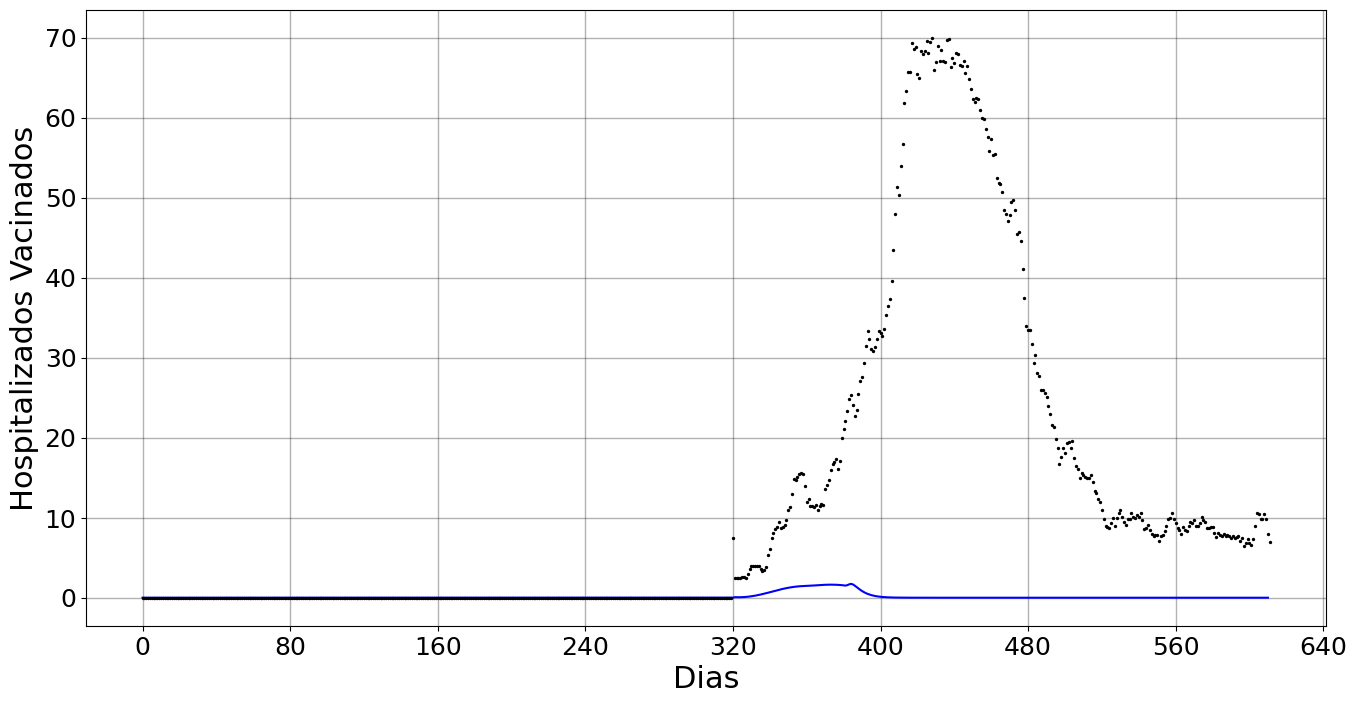

In [130]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = sol1.y[-2,:] #mortes acumulados

#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-1, 1)

ax.scatter(x_para_escala,  np.diff(dados_hospitalizados_vacinados), color='black',zorder=3,label='Reported data', s=2)
#Plot the fitted function as a line.
ax.plot(np.diff(N*qi),color='blue',label='Fitted function')
#Set the labels
ax.set_ylabel('Hospitalizados Vacinados',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)

# plt.vlines([ 333.15303923, 439.95810453], ymin=0, ymax=200)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
plot_hosp_vac = fig

#Show Graph       
plt.show()

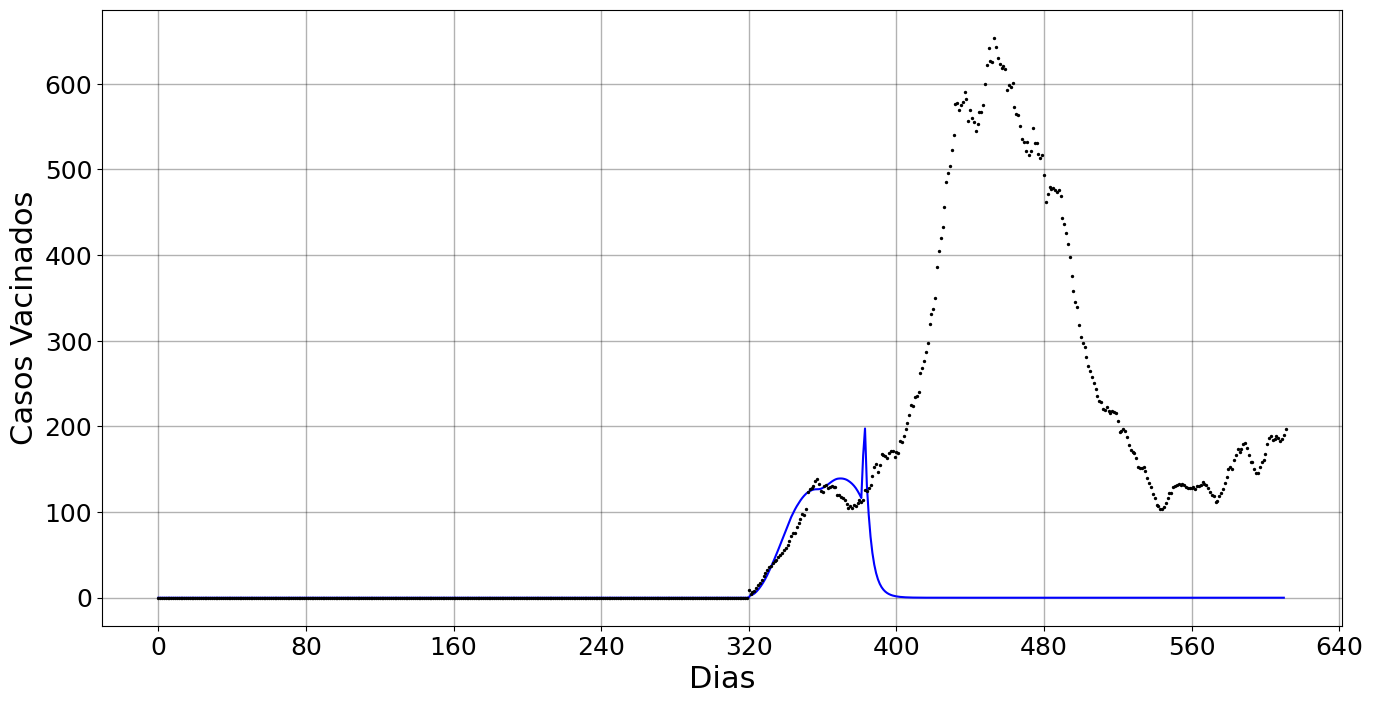

In [131]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = sol1.y[-1,:] #mortes acumulados

#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(dados_datas)-1, 1)

ax.scatter(x_para_escala,  np.diff(dados_infectados_vacinados), color='black',zorder=3,label='Reported data', s=2)
#Plot the fitted function as a line.
ax.plot(np.diff(N*qi),color='blue',label='Fitted function')
#Set the labels
ax.set_ylabel('Casos Vacinados',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)

# plt.vlines([ 333.15303923, 439.95810453], ymin=0, ymax=200)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)
plot_casos_vac = fig

#Show Graph       
plt.show()

(6500, 7)


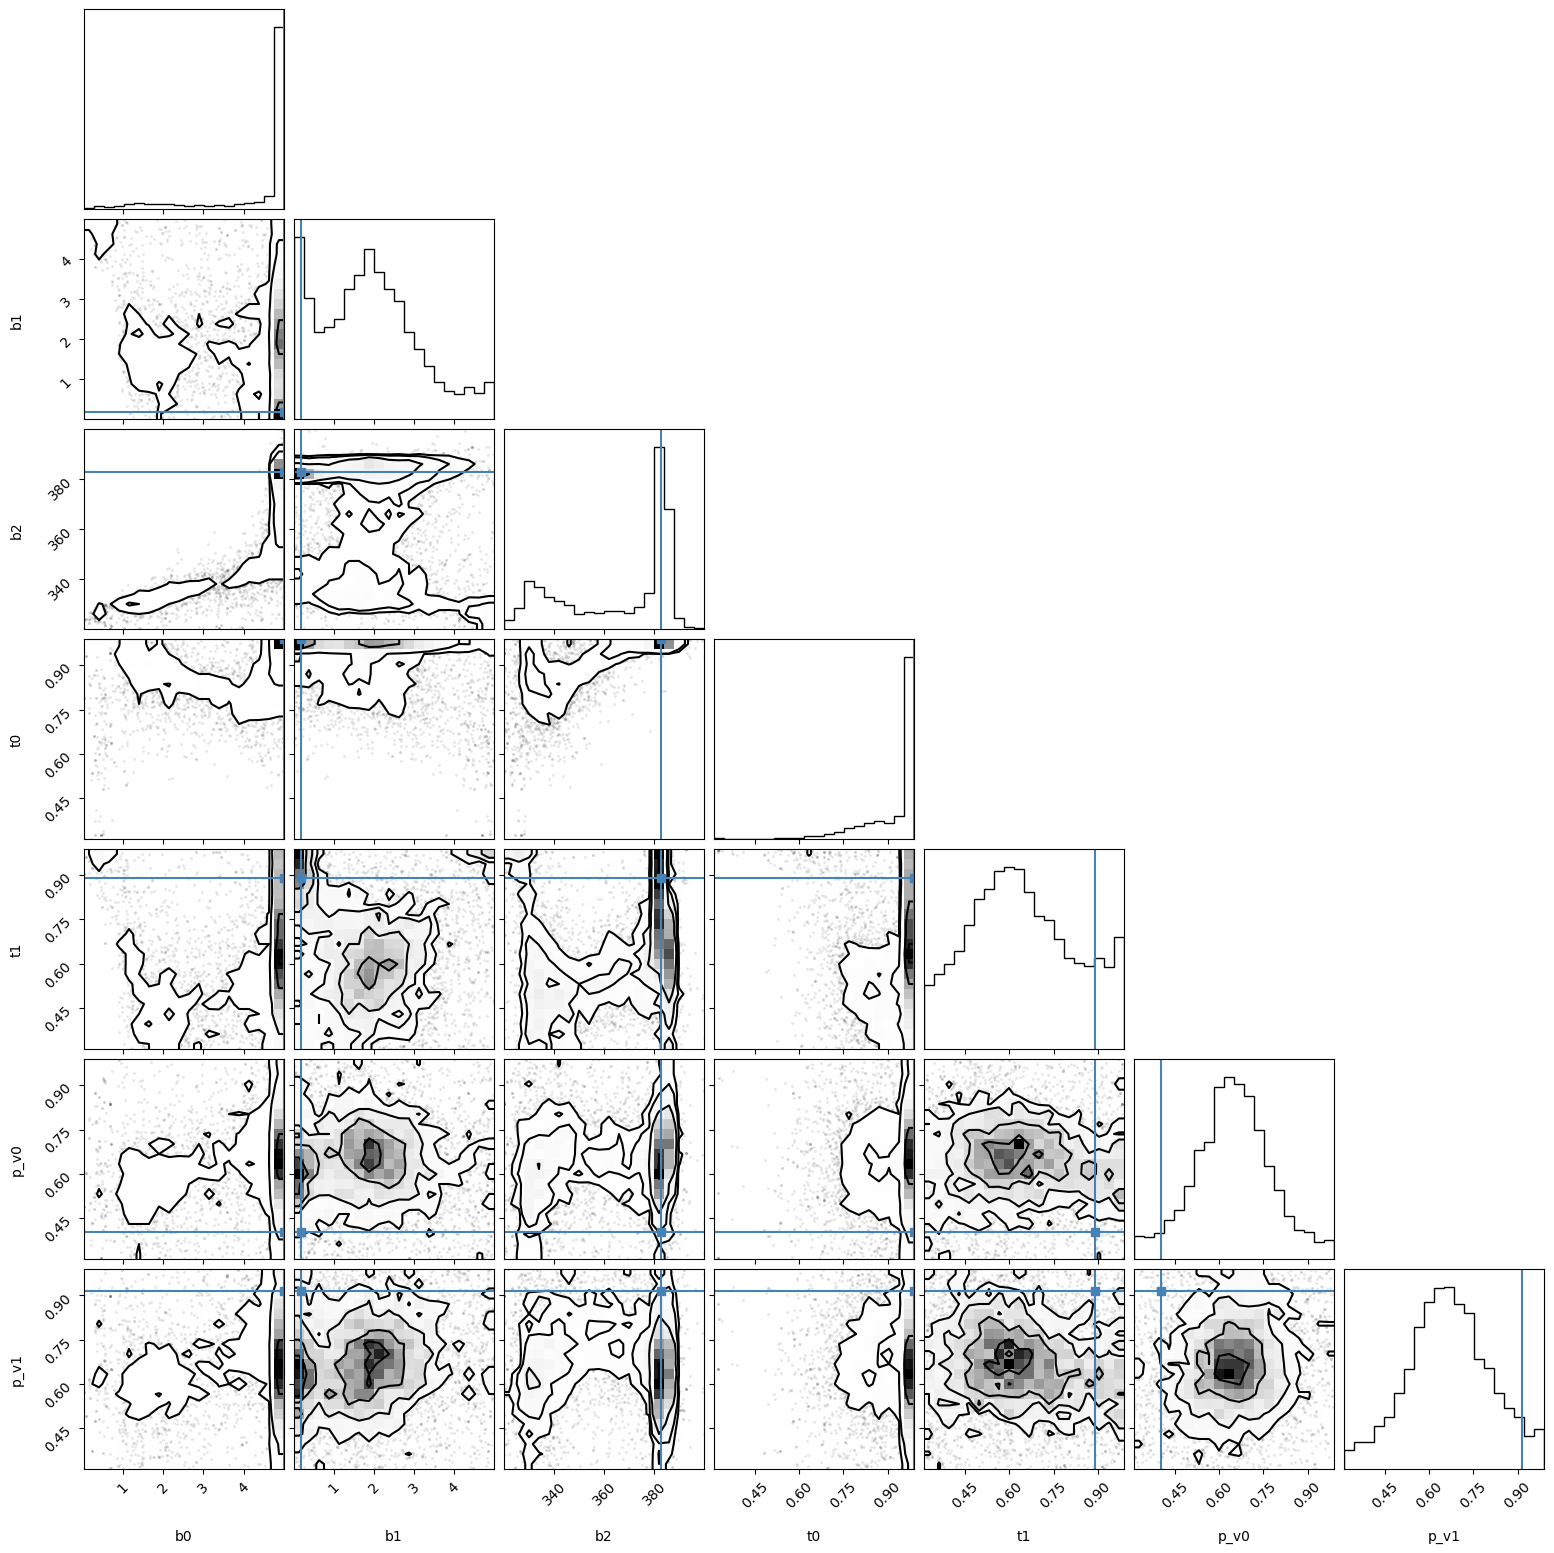

In [132]:
import corner
flat_samples = sampler1.get_chain(discard=100, thin=15, flat=True)
b0, b1, b2, t0, t1, p_v0, p_v1 = theta_max1
print(flat_samples.shape)
labels = ["b0","b1", "b2", "t0","t1", "p_v0", "p_v1"]
fig = corner.corner(
    flat_samples, labels=labels, truths=[b0, b1, b2, t0, t1, p_v0, p_v1]
);

corner_fig = fig
